# 🔧 Install & Import Dependencies


In [4]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # punkt_tab is optional

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

We will explore the generation of dense word representations from text corpora, analyze the quality of these representations. The goal is to understand how to represent word meaning in a high-dimensional space and how to transfer knowledge across languages.

Please use the links below to download text corpora. \
English: https://wortschatz.uni-leipzig.de/en/download/English \
Hindi: https://wortschatz.uni-leipzig.de/en/download/Hindi

# Load the English Corpus

In [5]:
# Load corpus
with open("D:\RESEARCH related\PreCog tasks\Language_representations\Data\eng_news_2020_300K\eng_news_2020_300K\eng_news_2020_300K-sentences.txt", "r", encoding='utf8') as f:
    sentences = f.readlines()
    sentences = [sentence.strip() for sentence in sentences]

print(f"Total sentences loaded: {len(sentences)}")

<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25692\3237838278.py:2: SyntaxWarning: invalid escape sequence '\R'
  with open("D:\RESEARCH related\PreCog tasks\Language_representations\Data\eng_news_2020_300K\eng_news_2020_300K\eng_news_2020_300K-sentences.txt", "r", encoding='utf8') as f:


Total sentences loaded: 300000


# preprocessing of data
1. Lowercase
2. Remove non-alphabetic characters (removing punctuations)
3. how about stop words removal --> they impact hugely in co occurence matrices so don't do it.
4. lemitization & stemming  (does this helpful for this task)
5. Tokenize words after all 

In [6]:
# Clean and tokenize
def preprocess(sentence):
    sentence = sentence.lower()  # Lowercase
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)  # Remove punctuations and numbers
    tokens = word_tokenize(sentence)  # Tokenize using NLTK
    return tokens

# Apply to all sentences
processed_sentences = [preprocess(s) for s in sentences]

# Show a few examples
for i in range(3):
    print(processed_sentences[i])

['will', 'go', 'toward', 'building', 'resilience', 'for', 'maines', 'businesses']
['millionverifier', 'an', 'email', 'services', 'company', 'that', 'provides', 'email', 'verification', 'and', 'deliverability', 'support']
['more', 'or', 'less']


### For this task, should we employ stemming or lemmatization❓ 
No. \
Lemmatization and stemming eliminate subtle meaning differences by reducing word forms to their base or root, which is why we avoid them. To better represent how words are used in various contexts, we aim to maintain all natural word forms in word embeddings.

### Build Vocabulary : after experimenting, build vocab_sizes with 15k words

In [7]:
# Flatten tokens to build vocab
flat_words = [word for sentence in processed_sentences for word in sentence]
vocab_counter = Counter(flat_words)

# Keep top N words
vocab_size = 10000  # You can experiment here with different different vocab_size like 10k, 20k etc
vocab = [word for word, freq in vocab_counter.most_common(vocab_size)]

Now that we've built the vocabulary from the most frequent words, how can we assign meaningful IDs to these words instead of just arbitrary numbers?

There are several strategies we can use:

Frequency-based indexing ---> (most common and efficient)

POS-based ordering ---> (useful for linguistic analysis)


# # POS-based order --> For linguistic analysis

In [8]:
# POS-based order --> For linguistic analysis

import nltk
nltk.download('averaged_perceptron_tagger_eng')

pos_tags = nltk.pos_tag(vocab)  # [('word1', 'NN'), ('word2', 'VB'), ...]

# Separate into POS categories
nouns = [word for word, tag in pos_tags if tag.startswith('NN')]
verbs = [word for word, tag in pos_tags if tag.startswith('VB')]
adjs  = [word for word, tag in pos_tags if tag.startswith('JJ')]

ordered_vocab = nouns + verbs + adjs
word2id = {word: i for i, word in enumerate(ordered_vocab)}
id2word = {i: word for i, word in enumerate(ordered_vocab)}

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### Building the Co-occurrence Matrix
We construct the co-occurrence matrix by counting how often word pairs appear within a context window, which can be adjusted based on experimentation. For each sentence, we update the matrix for every target-context word pair found within the specified window size.

### Choosing Window Size

Small (2-5 words): Captures local relationships (syntax). \
Medium (5-10 words): Captures semantic meaning.\
Large (>10 words): Captures broader context.

In [9]:
### Construct the Co-occurrence Matrix
import numpy as np
from tqdm import tqdm
cooc_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
window_size = 4  # To capture semantic meaning, keep the window size between 2 and 5.

for sentence in tqdm(processed_sentences):
    sentence = [word for word in sentence if word in word2id]
    for idx, word in enumerate(sentence):
        word_id = word2id[word]
        start = max(0, idx - window_size)
        end = min(len(sentence), idx + window_size + 1)
        for i in range(start, end):
            if i != idx:
                context_id = word2id[sentence[i]]
                cooc_matrix[word_id][context_id] += 1

100%|██████████| 300000/300000 [01:18<00:00, 3800.42it/s]


# What's next?

To turn that matrix into word embeddings, you need to apply a technique like: \

Method -----> What it does \
PCA / SVD -----> Reduce matrix to low-dimensional dense vectors \
NMF (Non-negative Matrix Factorization) ---> Factorizes co-occurrence matrix into interpretable non-negatives \
word2vec -----> Learns embeddings directly via neural nets (skip-gram/CBOW)

In [10]:
from sklearn.decomposition import NMF

# Experiment with different values of d
d_values = [50, 100, 200]
nmf_results = {}

for d in d_values:
    print(f"Applying NMF with d = {d}")
    nmf_model = NMF(n_components=d, init='nndsvd', random_state=42, max_iter=300)
    W = nmf_model.fit_transform(cooc_matrix)  # Shape: (N, d)
    nmf_results[d] = W
    print(f"NMF Embeddings Shape (d={d}):", W.shape)

Applying NMF with d = 50


d:\RESEARCH related\PreCog tasks\precog_venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NMF Embeddings Shape (d=50): (10000, 50)
Applying NMF with d = 100


d:\RESEARCH related\PreCog tasks\precog_venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NMF Embeddings Shape (d=100): (10000, 100)
Applying NMF with d = 200


d:\RESEARCH related\PreCog tasks\precog_venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


NMF Embeddings Shape (d=200): (10000, 200)


### select for better dimension based on average similarity

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Define word pairs to evaluate
sample_pairs = [('king', 'queen'), ('man', 'woman'), ('paris', 'france'), ('apple', 'fruit'), ('doctor', 'hospital')]

# Function to evaluate cosine similarity between word pairs
def evaluate_similarity(embeddings, word2id, word_pairs):
    scores = []
    for w1, w2 in word_pairs:
        if w1 in word2id and w2 in word2id:
            v1 = embeddings[word2id[w1]]
            v2 = embeddings[word2id[w2]]
            sim = cosine_similarity([v1], [v2])[0][0]
            scores.append((w1, w2, sim))
    return scores

# Track average scores across all dimensions
average_scores = {}

for d in nmf_results:
    print(f"\n🔍 Cosine Similarities for d = {d}:")
    results = evaluate_similarity(nmf_results[d], word2id, sample_pairs)
    total = 0
    for w1, w2, score in results:
        print(f"Cosine({w1}, {w2}) = {score:.4f}")
        total += score
    avg = total / len(results)
    average_scores[d] = avg
    print(f"✅ Average Cosine Similarity (d={d}) = {avg:.4f}")

# Print the best d based on average similarity
best_d = max(average_scores, key=average_scores.get)
print(f"\n🏆 Best performing embedding dimension based on average similarity: d = {best_d}")


🔍 Cosine Similarities for d = 50:
Cosine(king, queen) = 0.8026
Cosine(man, woman) = 0.9502
Cosine(paris, france) = 0.5265
Cosine(apple, fruit) = 0.5608
Cosine(doctor, hospital) = 0.6753
✅ Average Cosine Similarity (d=50) = 0.7031

🔍 Cosine Similarities for d = 100:
Cosine(king, queen) = 0.6326
Cosine(man, woman) = 0.9400
Cosine(paris, france) = 0.7100
Cosine(apple, fruit) = 0.3534
Cosine(doctor, hospital) = 0.5743
✅ Average Cosine Similarity (d=100) = 0.6421

🔍 Cosine Similarities for d = 200:
Cosine(king, queen) = 0.5819
Cosine(man, woman) = 0.9349
Cosine(paris, france) = 0.5119
Cosine(apple, fruit) = 0.5100
Cosine(doctor, hospital) = 0.6750
✅ Average Cosine Similarity (d=200) = 0.6427

🏆 Best performing embedding dimension based on average similarity: d = 50


# Check for cosine similarity between words

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two words
def get_similarity(word1, word2, reduced_matrix, word2id):
    if word1 in word2id and word2 in word2id:
        vec1 = reduced_matrix[word2id[word1]]
        vec2 = reduced_matrix[word2id[word2]]
        return cosine_similarity([vec1], [vec2])[0][0]
    else:
        return f"❌ One or both words not in vocabulary."

# Example checks for NMF reduced embedding of size 200
print("king vs queen →", get_similarity("king", "queen", nmf_results[200], word2id))
print("king vs sword →", get_similarity("king", "sword", nmf_results[200], word2id))
print("king vs virat →", get_similarity("king", "virat", nmf_results[200], word2id))

king vs queen → 0.5819198
king vs sword → 0.566301
king vs virat → ❌ One or both words not in vocabulary.


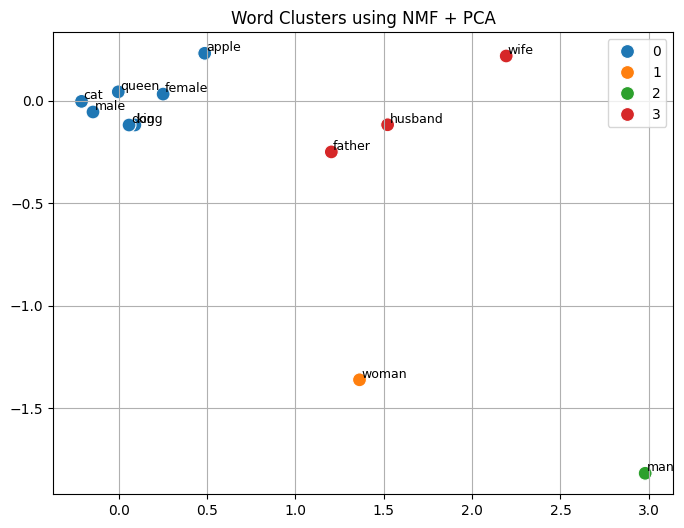

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Words to visualize
cluster_words = ["king", "queen", "man", "woman", "apple", "dog", "cat", "father", "mother", "male", "female", "husband", "wife"]

# Step 1: Choose your NMF embedding (e.g., 50D or 100D)
embedding_nmf = nmf_results[200]  # Make sure you used 50 in your previous reduction step

# Step 2: Reduce to 2D using PCA for plotting
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_nmf)

# Step 3: Extract the vectors for your chosen words
vecs = [embedding_2d[word2id[word]] for word in cluster_words if word in word2id]

# Step 4: Cluster them
labels = KMeans(n_clusters=4, random_state=42).fit_predict(vecs)

# Step 5: Plot with annotations
plt.figure(figsize=(8, 6))
sns.scatterplot(x=[v[0] for v in vecs], y=[v[1] for v in vecs], hue=labels, palette="tab10", s=100)

for word in cluster_words:
    if word in word2id:
        x, y = embedding_2d[word2id[word]]
        plt.text(x + 0.01, y + 0.01, word, fontsize=9)

plt.title("Word Clusters using NMF + PCA")
plt.grid(True)
plt.show()

## how about checking for Contextualized Evaluation ??

Contextual Similarity Shift (e.g. “bank” in finance vs river)

In [14]:
def build_contextual_cooc_matrix(context_lines, target_words, shared_vocab=None, window_size=2):
    word2id = {} if shared_vocab is None else {word: idx for idx, word in enumerate(shared_vocab)}
    data = []

    for line in context_lines:
        tokens = line.lower().split()
        for idx, word in enumerate(tokens):
            if word in target_words:
                context_ids = []
                for i in range(idx - window_size, idx + window_size + 1):
                    if 0 <= i < len(tokens) and i != idx:
                        context_word = tokens[i]
                        if context_word not in word2id:
                            word2id[context_word] = len(word2id)
                        context_ids.append(word2id[context_word])
                data.append((word2id[word], context_ids))

    vocab = [None] * len(word2id)
    for w, i in word2id.items():
        vocab[i] = w

    # Create matrix
    matrix = np.zeros((len(word2id), len(word2id)))
    for center, contexts in data:
        for context in contexts:
            matrix[center, context] += 1

    return matrix, word2id, vocab

In [15]:
# 🧾 Example: compare "bank" in two contexts
finance_corpus = [
    "The bank approved a loan to the company",
    "The central bank regulated monetary policies",
    "She works in a private bank as a clerk"
]

river_corpus = [
    "The boat sailed along the river bank",
    "They camped near the grassy bank of the river",
    "The bank was flooded after heavy rains"
]

# Build shared vocabulary
all_tokens = set()
for line in finance_corpus + river_corpus:
    all_tokens.update(line.lower().split())
shared_vocab = sorted(list(all_tokens))

# Build co-occurrence matrices
matrix_fin, word2id_fin, _ = build_contextual_cooc_matrix(finance_corpus, ['bank'], shared_vocab)
matrix_riv, word2id_riv, _ = build_contextual_cooc_matrix(river_corpus, ['bank'], shared_vocab)

# Get contextual vectors
vec_bank_fin = matrix_fin[word2id_fin['bank']]
vec_bank_riv = matrix_riv[word2id_riv['bank']]

# Compute contextual similarity
similarity_shift = cosine_similarity([vec_bank_fin], [vec_bank_riv])[0][0]
print(f"📉 Contextual similarity shift for 'bank': {similarity_shift:.4f}")

📉 Contextual similarity shift for 'bank': 0.4005


# Evaluate the Quality of the Embeddings

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define analogies: A is to B as C is to D
analogy_tasks = [
    ('king', 'man', 'woman', 'queen'),
    ('paris', 'france', 'italy', 'rome'),
    ('he', 'him', 'her', 'she'),
    ('strong', 'stronger', 'fast', 'faster'),
    ('good', 'better', 'bad', 'worse'),
]

def evaluate_analogies(embedding_matrix, word2id, id2word, analogies, top_k=5):
    correct_top1 = 0
    correct_topk = 0
    total = 0

    for a, b, c, expected in analogies:
        if all(word in word2id for word in [a, b, c, expected]):
            vec_a = embedding_matrix[word2id[a]]
            vec_b = embedding_matrix[word2id[b]]
            vec_c = embedding_matrix[word2id[c]]
            target_vec = vec_a - vec_b + vec_c

            similarities = cosine_similarity([target_vec], embedding_matrix)[0]

            # Avoid retrieving input words
            for word in (a, b, c):
                similarities[word2id[word]] = -np.inf

            topk_indices = similarities.argsort()[::-1][:top_k]
            topk_words = [id2word[i] for i in topk_indices]

            if expected in topk_words:
                correct_topk += 1
                if topk_words[0] == expected:
                    correct_top1 += 1
            total += 1
        else:
            print(f"Skipping: {a}-{b}+{c}={expected} (missing word)")

    # Print results
    print(f"\n📊 Total Analogies Tested: {total}")
    print(f"✅ Top-1 Accuracy: {correct_top1 / total:.2%}")
    print(f"✅ Top-{top_k} Accuracy: {correct_topk / total:.2%}")
    print(f"❌ Error Rate (Top-1): {100 - (correct_top1 / total * 100):.2f}%")
    print(f"❌ Error Rate (Top-{top_k}): {100 - (correct_topk / total * 100):.2f}%")

# Example: Run it on NMF 100D embeddings
evaluate_analogies(nmf_results[100], word2id, id2word, analogy_tasks, top_k=5)

Skipping: he-him+her=she (missing word)
Skipping: strong-stronger+fast=faster (missing word)

📊 Total Analogies Tested: 3
✅ Top-1 Accuracy: 0.00%
✅ Top-5 Accuracy: 0.00%
❌ Error Rate (Top-1): 100.00%
❌ Error Rate (Top-5): 100.00%


### saving this model as 4_embedding correspond to this 4_POS_based_NMF file

In [17]:
import numpy as np
import os

# Define where you want to save the embeddings
save_path = "D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models"
os.makedirs(save_path, exist_ok=True)

embedding_to_save = nmf_results[200]  # NMF with 200 dimensions

# Save as a numbered file (e.g., 4_embeddings.npy)
np.save(os.path.join(save_path, "4_embeddings.npy"), embedding_to_save)

print("✅ Embedding saved successfully to '4_embeddings.npy'")


✅ Embedding saved successfully to '4_embeddings.npy'


### storing embeddings in pickle formate 

In [18]:
import pickle
import numpy as np
import os

embedding_matrix = nmf_results[200]  # NMF with 200 dimensions

# Convert to dictionary format: {word: embedding}
word2embedding = {word: embedding_matrix[word2id[word]] for word in word2id if word2id[word] < embedding_matrix.shape[0]}

# Save as pickle
save_path = "D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models"
os.makedirs(save_path, exist_ok=True)

with open(os.path.join(save_path, "4_word_embeddings.pkl"), 'wb') as f:
    pickle.dump(word2embedding, f)

print("✅ Word embeddings dictionary saved as 4_word_embeddings.pkl")


✅ Word embeddings dictionary saved as 4_word_embeddings.pkl
